# Introduction
This lab uses two public datasets in BigQuery: weather data from the US National Oceanic and Atmospheric Administration (NOAA), and bicycle rental data from New York City.

Open BigQuery Console
1. In the Google Cloud Console, select Navigation menu > BigQuery.
The Welcome to BigQuery in the Cloud Console message box opens. This message box provides a link to the quickstart guide and lists UI updates.

2. Click Done.

# Task 1. Explore bicycle rental data
1. In the left pane, click + Add , then click Star a project by name, next in the pop-up window type bigquery-public-data, finally click Star.

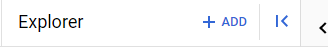

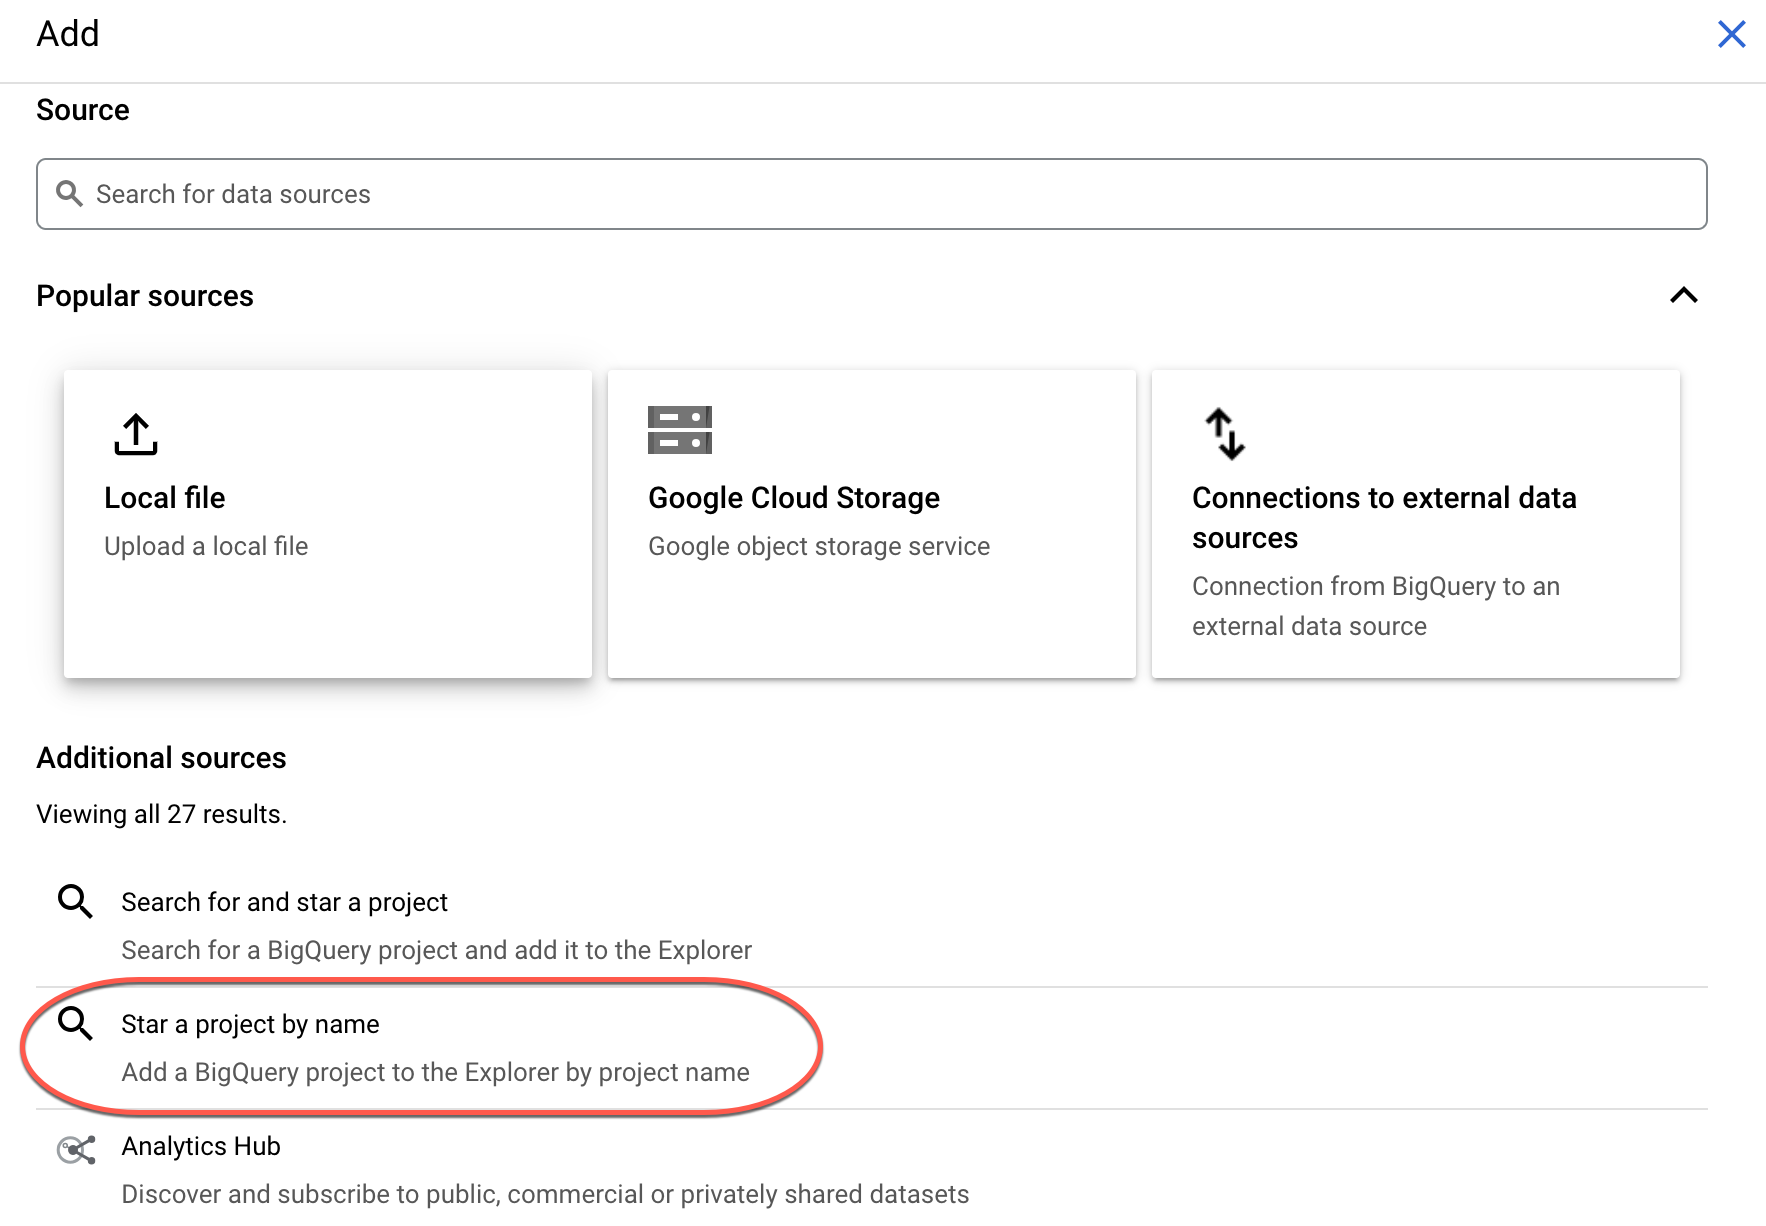

2. In the BigQuery console, you see two projects in the left pane, one named your Qwiklabs project ID, and one named bigquery-public-data.

3. In the left pane of the BigQuery console, select bigquery-public-data > new_york_citibike > citibike_trips table.

4. In the Table (citibike_trips) window, click the Schema tab.

5. Examine the column names and the datatypes.

6. Click the Blue + button to compose a new query.

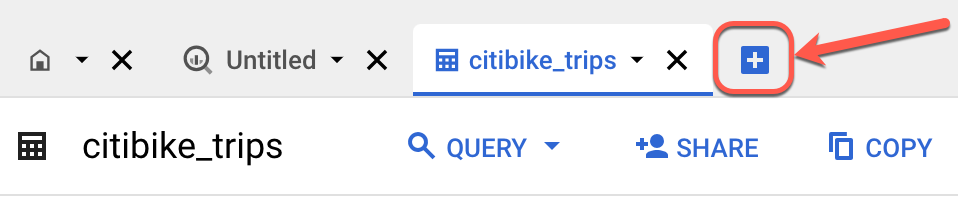

Enter the following query:

In [ ]:
SELECT
  MIN(start_station_name) AS start_station_name,
  MIN(end_station_name) AS end_station_name,
  APPROX_QUANTILES(tripduration, 10)[OFFSET (5)] AS typical_duration,
  COUNT(tripduration) AS num_trips
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE
  start_station_id != end_station_id
GROUP BY
  start_station_id,
  end_station_id
ORDER BY
  num_trips DESC
LIMIT
  10


7. Click Run. Look at the result and try to determine what this query does ?

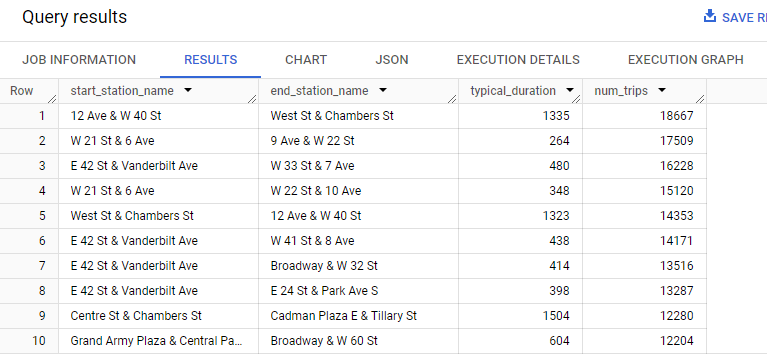

8. Next, run the query below to find another interesting fact: total distance traveled by each bicycle in the dataset. Note that the query limits the results to only top 5.

In [ ]:
WITH
  trip_distance AS (
SELECT
  bikeid,
  ST_Distance(ST_GeogPoint(s.longitude,
      s.latitude),
    ST_GeogPoint(e.longitude,
      e.latitude)) AS distance
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`,
  `bigquery-public-data.new_york_citibike.citibike_stations` as s,
  `bigquery-public-data.new_york_citibike.citibike_stations` as e
WHERE
  start_station_name  = s.name
  AND end_station_name  = e.name)
SELECT
  bikeid,
  SUM(distance)/1000 AS total_distance
FROM
  trip_distance
GROUP BY
  bikeid
ORDER BY
  total_distance DESC
LIMIT
  5

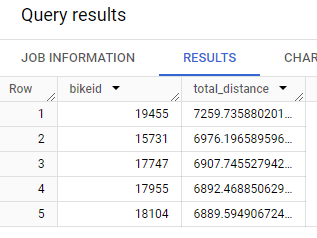

# Task 2. Explore the weather dataset
1. In the left pane of the BigQuery Console, select the newly added bigquery-public-data project and select ghcn_d > ghcnd_2015.

2. Then click on the Preview tab. Your console should resemble the following:

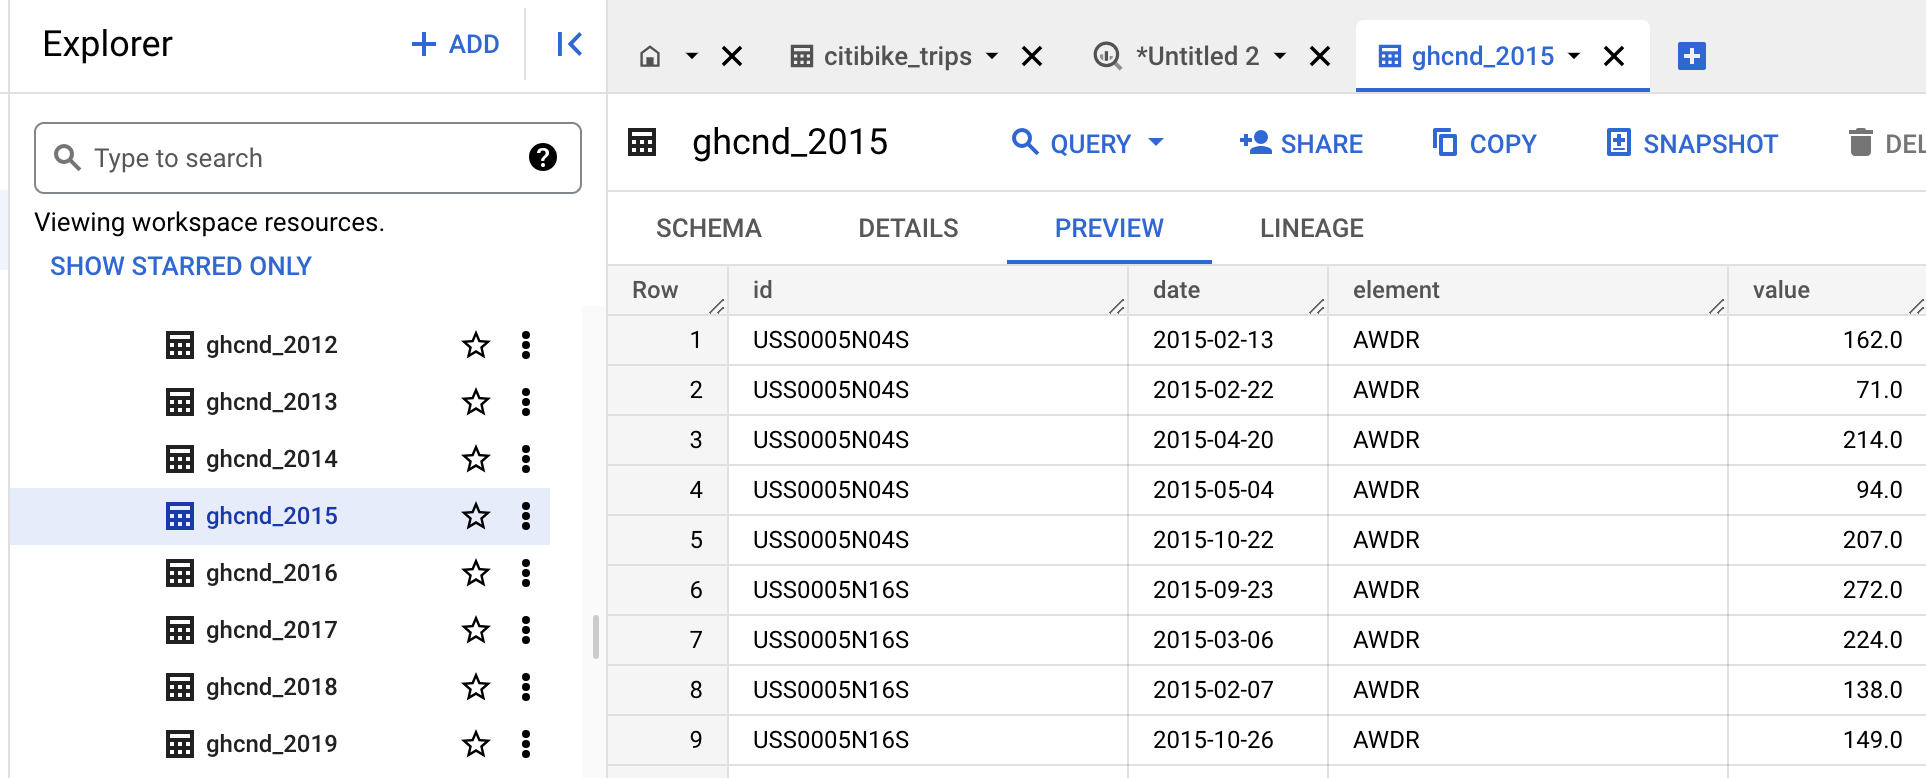

Examine the columns and some of the data values.

3. Click the Blue + button to compose a new query and enter the following:

In [ ]:
SELECT
  wx.date,
  wx.value/10.0 AS prcp
FROM
  `bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
WHERE
  id = 'USW00094728'
  AND qflag IS NULL
  AND element = 'PRCP'
ORDER BY
  wx.date

4. Click Run.

This query will return rainfall (in mm) for all days in 2015 from a weather station in New York whose id is provided in the query (the station corresponds to NEW YORK CNTRL PK TWR ).

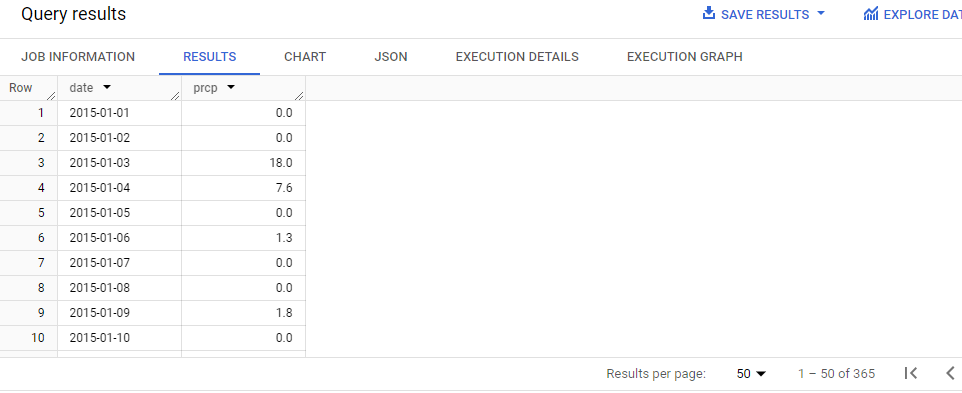

# Task 3. Find correlation between rain and bicycle rentals
How about joining the bicycle rentals data against weather data to learn whether there are fewer bicycle rentals on rainy days?

1. Click the Blue + button to compose a new query and enter the following:

In [ ]:
WITH bicycle_rentals AS (
  SELECT
    COUNT(starttime) as num_trips,
    EXTRACT(DATE from starttime) as trip_date
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  GROUP BY trip_date
),

rainy_days AS
(
SELECT
  date,
  (MAX(prcp) > 5) AS rainy
FROM (
  SELECT
    wx.date AS date,
    IF (wx.element = 'PRCP', wx.value/10, NULL) AS prcp
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
  WHERE
    wx.id = 'USW00094728'
)
GROUP BY
  date
)

SELECT
  ROUND(AVG(bk.num_trips)) AS num_trips,
  wx.rainy
FROM bicycle_rentals AS bk
JOIN rainy_days AS wx
ON wx.date = bk.trip_date
GROUP BY wx.rainy


2. Click Run.

Now you can see the results of joining the bicycle rental dataset with a weather dataset that comes from a completely different source:

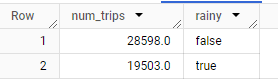

Running the query yields that, yes, New Yorkers ride the bicycle 47% fewer times when it rains.